# Data

## Generate

In [3]:
import pandas as pd
import FinanceDataReader as fdr
import plotly.express as px

In [4]:
tickers = ['KS11', 'S&P500', 'CL=F', 'GC=F', 'USD/KRW', 'US10YT', '^NYICDX', 'SSEC', 'HSI', 'N225', 'FTSE', 'GDAXI', 'USD/EUR',
          'USD/CNY', 'USD/JPY', '^STOXX50E']
names = ['KOSPI', 'S&P500', 'WTI', 'GOLD', 'USD/KRW', 'US10YT', 'DXY', 'SSEC', 'HSI', 'N225', 'FTSE100', 'DAX30', 'USD/EUR',
        'USD/CNY', 'USD/JPY', 'STOXX50']
column = 'Close'

df_macro = None
for name, tkr in zip(names, tickers):
    df = fdr.DataReader(tkr)
    df = df[column].rename(name)
    if df_macro is None:
        df_macro = df
    else:
        df_macro = pd.concat([df_macro, df], axis=1)

<Axes: >

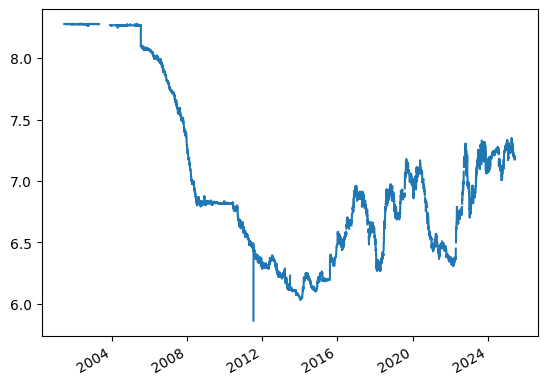

In [5]:
#df_macro.tail().head()
df_macro['USD/CNY'].plot()

In [6]:
idx = df_macro['USD/CNY'].idxmin()
df_macro.loc[idx, 'USD/CNY'] = None

*Benchmark Interest Rate*
- https://fred.stlouisfed.org/series/FEDFUNDS
- https://data.ecb.europa.eu/main-figures/ecb-interest-rates-and-exchange-rates/key-ecb-interest-rates
- https://kr.investing.com/rates-bonds/south-korea-10-year-bond-yield-historical-data
- https://fred.stlouisfed.org/series/USREC

In [7]:
files = ['FEDFUNDS', 'ECBMRO', 'KR10Y', 'USREC'] 
cols = [0, 1, 0, 0]

for f, c in zip(files, cols):
    df_ff = pd.read_csv(f'data/{f}.csv', parse_dates=[0], index_col=0).rename_axis('date').iloc[:, c].rename(f)
    df_macro = df_macro.join(df_ff)
    
df_macro = df_macro[df_macro.columns.sort_values()]

In [9]:
f = 'data/macro_indicators_250617.csv'
df_macro.to_csv(f)

## Review

*Sampling*

In [ ]:
df = df_macro.stack().swaplevel().rename_axis(['ticker', 'date']).sort_index()

# Create a groupby on ticker and date.to_period('M')
grouped = df.groupby([df.index.get_level_values('ticker'),
                     df.index.get_level_values('date').to_period('M')])

# Get the index (MultiIndex) of the max per group
idx1 = grouped.idxmax()
idx2 = grouped.idxmin()
idx = pd.concat([idx1, idx2]).drop_duplicates()

# Use .loc to extract the max values
df = df.loc[idx].unstack('ticker').sort_index()
df

*Normalize*

In [9]:
from sklearn.preprocessing import MinMaxScaler

start, end = None, None
#start, end = '2005', '2018'
#start, end = '2018', '2022'

df = df.loc[start:end]

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [ ]:
# plot
df = df.stack().rename('Normalized').rename_axis(['Date', 'Ticker']).reset_index()
fig = px.line(df, x="Date", y="Normalized", color='Ticker', height=500)
fig.update_traces(hovertemplate=None, line=dict(width=1))
fig.update_layout(hovermode="x unified")
fig.show()

## Category

In [5]:
import pandas as pd
file = 'macro_indicators_250617.csv'
path = 'data'
df_macro = pd.read_csv(f'{path}/{file}', parse_dates=[0], index_col=0).rename_axis('date')
df_macro.columns

Index(['DAX30', 'DXY', 'ECBMRO', 'FEDFUNDS', 'FTSE100', 'GOLD', 'HSI', 'KOSPI',
       'KR10Y', 'N225', 'S&P500', 'SSEC', 'STOXX50', 'US10YT', 'USD/CNY',
       'USD/EUR', 'USD/JPY', 'USD/KRW', 'USREC', 'WTI'],
      dtype='object')

In [6]:
cat = ['market', 'exchange', 'benchmark', 'benchmark', 'market', 'commodity', 'market', 'market', 
       'yield', 'market', 'market', 'market', 'market', 'yield', 'exchange',
       'exchange', 'exchange', 'exchange', 'benchmark', 'commodity']

cat = dict(zip(df_macro.columns, cat))
cat

{'DAX30': 'market',
 'DXY': 'exchange',
 'ECBMRO': 'benchmark',
 'FEDFUNDS': 'benchmark',
 'FTSE100': 'market',
 'GOLD': 'commodity',
 'HSI': 'market',
 'KOSPI': 'market',
 'KR10Y': 'yield',
 'N225': 'market',
 'S&P500': 'market',
 'SSEC': 'market',
 'STOXX50': 'market',
 'US10YT': 'yield',
 'USD/CNY': 'exchange',
 'USD/EUR': 'exchange',
 'USD/JPY': 'exchange',
 'USD/KRW': 'exchange',
 'USREC': 'benchmark',
 'WTI': 'commodity'}

In [7]:
title = {
    'DAX30': 'German Stock Index',
    'DXY': 'U.S. Dollar Index',
    'ECBMRO': 'ECB Interest Rates',
    'FEDFUNDS': 'Federal Funds Effective Rate',
    'FTSE100': 'FTSE 100 Index',
    'GOLD': 'Gold Futures',
    'HSI': 'Hang Seng Index',
    'KOSPI': 'KOSPI',
    'KR10Y': 'Korea Government Bonds 10 YR Yield',
    'N225': 'Nikkei 225',
    'S&P500': "Standard and Poor's 500",
    'SSEC': 'Shanghai Stock Exchange',
    'STOXX50': 'EURO STOXX 50',
    'US10YT': '10-Year U.S. Treasury Bond Yield',
    'USD/CNY': '1 USD to CNY',
    'USD/EUR': '1 USD to EUR',
    'USD/JPY': '1 USD to JPY',
    'USD/KRW': '1 USD to KRW',
    'USREC': 'Recession Indicators for the United States',
    'WTI': 'West Texas Intermediate'
}

In [9]:
file = 'macro_indicator_category_250617.csv'
path = 'data'
(pd.DataFrame.from_dict({'category':cat, 'title':title}, orient='columns').rename_axis('indicator')
 .to_csv(f'{path}/{file}')
)

# Visualization

In [1]:
from pf_macro import app

In [2]:
app.run_server(debug=True, port=8100)

# testing

In [6]:
tkr = '^STOXX50E'
tkr = 'GC=F'
df = fdr.DataReader(tkr)

In [11]:
df.index.max().year

2025

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#start, end = None, None
#start, end = '2005', '2018'
start, end = '2018', '2022'
window = 1

df = df_macro.loc[start:end]

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Normalize
df[names] = df[names].apply(lambda x: x.ffill().dropna().rolling(window=window, center=True).mean())
df = df.dropna(how='all').ffill()

# plot
df = df.stack().rename('Normalized').rename_axis(['Date', 'Ticker']).reset_index()
fig = px.line(df, x="Date", y="Normalized", color='Ticker', height=500)
fig.update_traces(hovertemplate=None, line=dict(width=1))
fig.update_layout(hovermode="x unified")
fig.show()

In [4]:
import pandas as pd

# category
file = 'macro_indicator_category_250610.csv'
path = 'data'
data_category = pd.read_csv(f'{path}/{file}', index_col=0)
data_category

,category
indicator,
DAX30,market
DXY,rate
ECBMRO,exchange
FEDFUNDS,rate
FTSE100,market
GOLD,commodity
HSI,market
KOSPI,market
KR10Y,rate


In [5]:
file = 'macro_indicator_category_250610.csv'
path = 'data'
df = pd.read_csv(f'{path}/{file}', index_col=0)
data_category = df['category'].to_dict()
titles = df['title'].to_dict()
titles

{'DAX30': 'German Stock Index',
 'DXY': 'U.S. Dollar Index',
 'ECBMRO': 'ECB Interest Rates',
 'FEDFUNDS': 'Federal Funds Effective Rate',
 'FTSE100': 'FTSE 100 Index',
 'GOLD': 'Gold Futures',
 'HSI': 'Hang Seng Index',
 'KOSPI': 'KOSPI',
 'KR10Y': 'Korea Government Bonds 10 YR Yield',
 'N225': 'Nikkei 225',
 'S&P500': "Standard and Poor's 500",
 'SSEC': 'Shanghai Stock Exchange',
 'STOXX50': 'EURO STOXX 50',
 'US10YT': '10-Year U.S. Treasury Bond Yield',
 'USD/CNY': '1 USD to CNY',
 'USD/EUR': '1 USD to EUR',
 'USD/JPY': '1 USD to JPY',
 'USD/KRW': '1 USD to KRW',
 'WTI': 'West Texas Intermediate'}

In [9]:
import pandas as pd

# Your original dicts
dict1 = {0: 'Alice', 1: 'Bob', 2: 'Charlie'}
dict2 = {0: 25, 1: 30, 2: 22}

# Combine them into a dict of columns
data = {
    'Name': dict1,
    'Age': dict2
}

# Create DataFrame with orient='index', then transpose
df = pd.DataFrame.from_dict(data, orient='columns')

print(df)

      Name  Age
0    Alice   25
1      Bob   30
2  Charlie   22
